In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils import set_seed

In [2]:
set_seed(42)
sample_size = 1000

Random seed 42 has been set.


In [3]:
from rdrobust import rdrobust
import pandas as pd

def exp_toy(sample_size):
    set_seed(42)
    Y = np.random.binomial(1, .5, sample_size)
    r_x = np.random.uniform(0, 1, sample_size)
    human_predictions = [0] * len(Y)
    for i in range(len(Y)):
            coin = np.random.binomial(1,  .90, 1)[0]
            if coin == 1:
                human_predictions[i] = Y[i]
            else:
                human_predictions[i] = 1 - Y[i]
    h = np.array(human_predictions)
    ml_predictions = [0] * len(Y)
    for i in range(len(Y)):
            coin = np.random.binomial(1, .80 , 1)[0]
            if coin == 1:
                ml_predictions[i] = Y[i]
            else:
                ml_predictions[i] = 1 - Y[i]
    f = np.array(ml_predictions)
    target_coverages = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    estimated_taus = []
    estimated_pvs = []
    estimated_se = []
    estimated_ci = []
    estimated_ci_low = []
    estimated_ci_high = []
    df = pd.DataFrame()
    for target_coverage in target_coverages:
            # here we consider the case where there is a limited amount of instances that can be deferred to humans
            if (target_coverage is not None) and (target_coverage < 1):
                threshold = target_coverage
                deferred = np.where(r_x >= threshold, 1, 0)
            correct = np.where(
                deferred == 1,
                h == Y,
                f == Y,
            ).astype(float)
            tt = rdrobust(correct, r_x, c=threshold)
            tmp = pd.DataFrame()
            tmp['target_coverage'] = [target_coverage]
            tau_rd = tt.coef.iloc[2].iloc[0]
            tmp['coef_rob'] = [tau_rd]
            pv_rd = tt.pv.iloc[2].iloc[0]
            tmp['pv_rob'] = [pv_rd]
            se_rd = tt.se.iloc[2].iloc[0]
            tmp['se_rob'] = [se_rd]
            ci_rd = tt.ci.iloc[2].iloc[0], tt.ci.iloc[2].iloc[1]
            ci_rd_low = tt.ci.iloc[2].iloc[0]
            tmp['ci_rob_l'] = [ci_rd_low]
            ci_rd_high = tt.ci.iloc[2].iloc[1]
            tmp['ci_rob_h'] = [ci_rd_high]
            estimated_taus.append(tau_rd)
            estimated_pvs.append(pv_rd)
            estimated_se.append(se_rd)
            estimated_ci.append(ci_rd)
            estimated_ci_low.append(ci_rd_low)
            estimated_ci_high.append(ci_rd_high)
            df = pd.concat([df, tmp])
    df["n"] = sample_size
    return df

In [5]:
# db = pd.DataFrame()
# for s in [1000, 2000, 5000, 10000, 100000, 1000000]:
#     df = exp_toy(s)
#     db = pd.concat([db, df])
# db.to_csv("toy_example.csv")
db = pd.read_csv("../toy_example.csv")

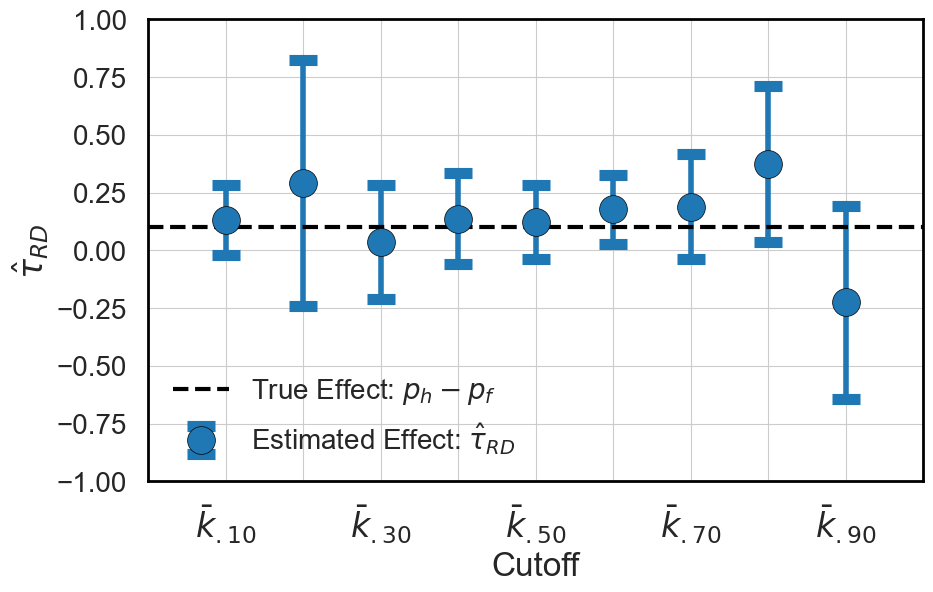

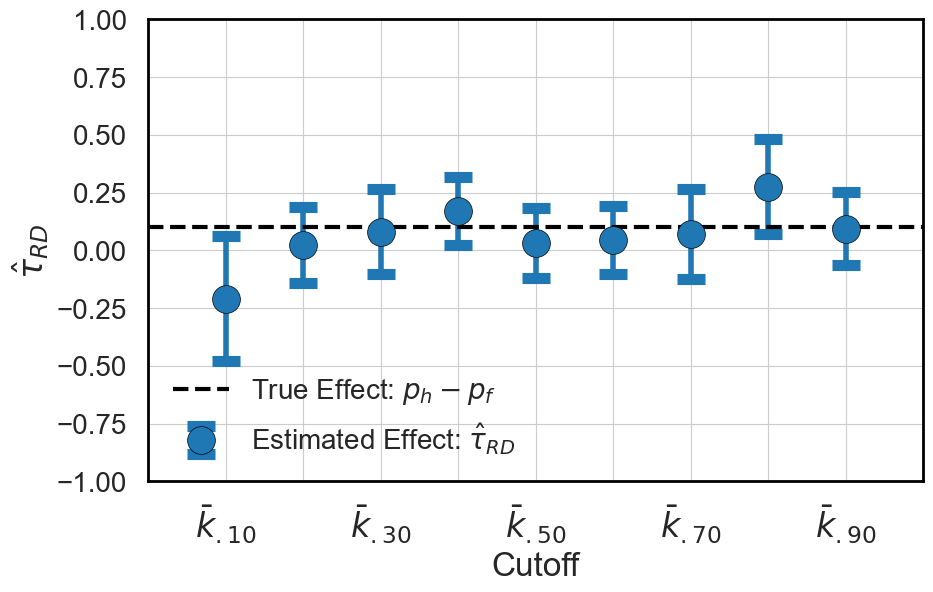

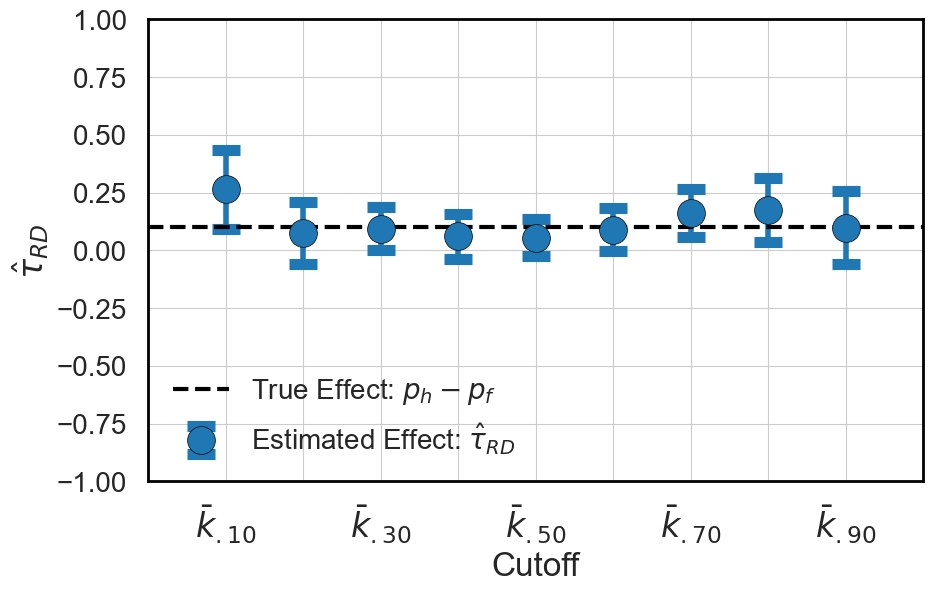

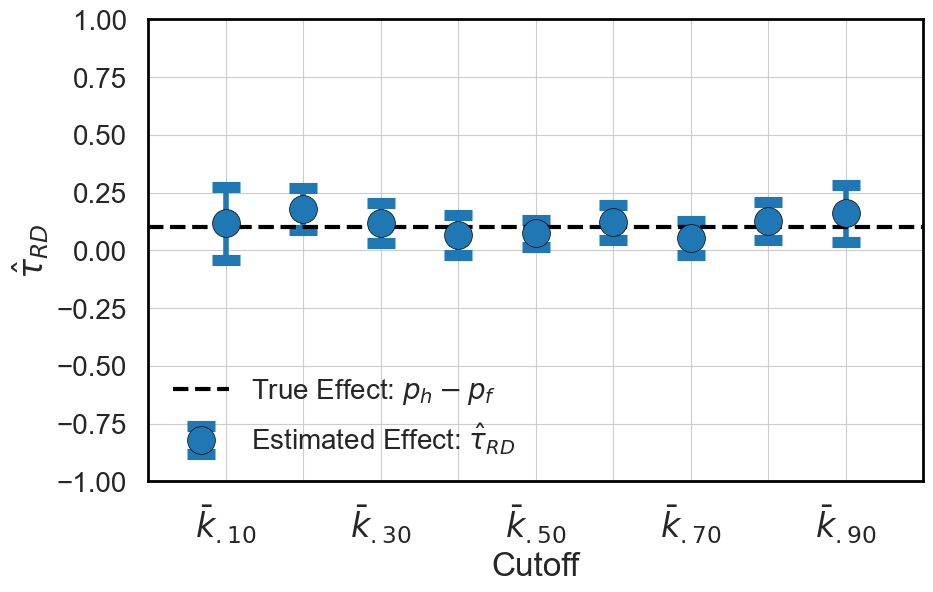

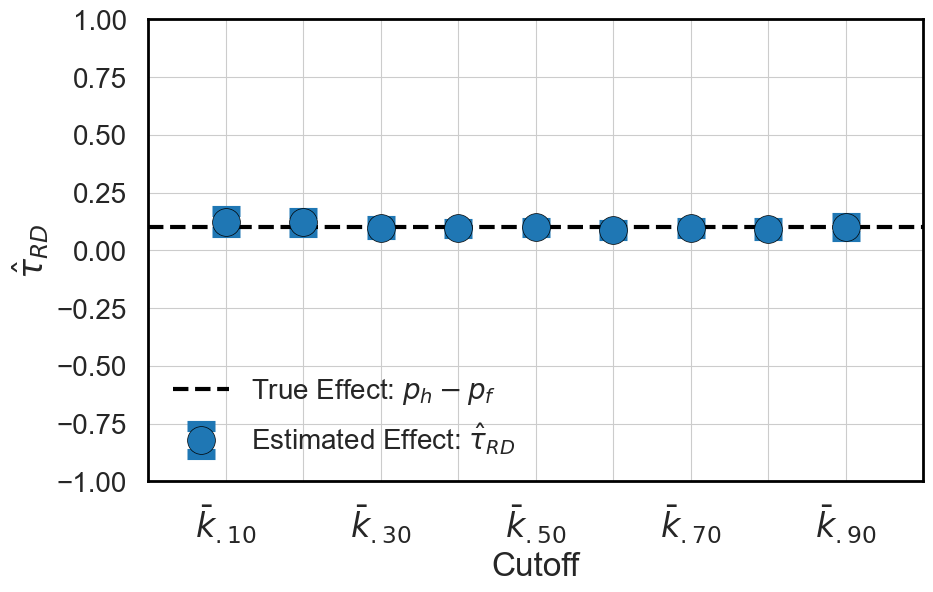

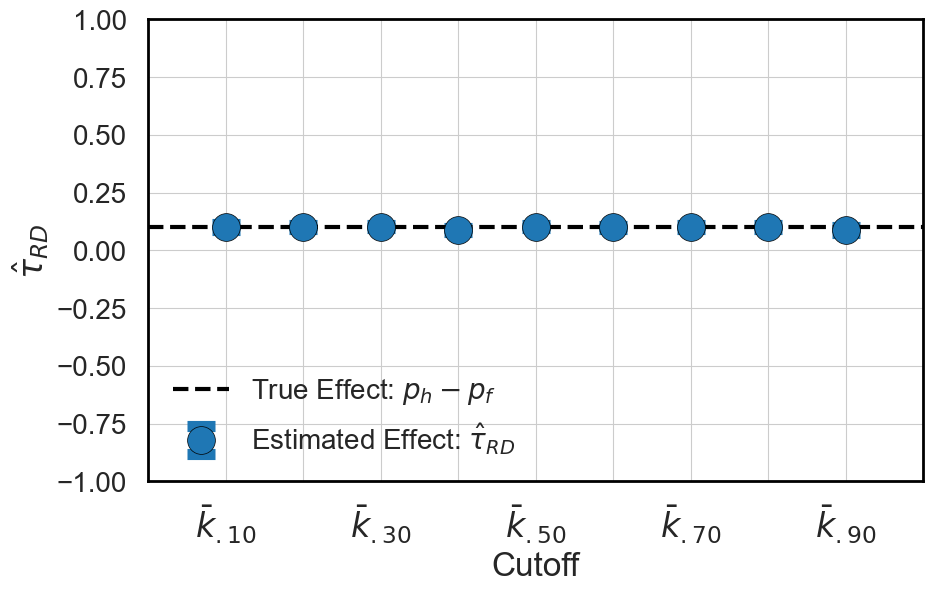

In [17]:

img_fold = 'C:/Users/andre/Dropbox/Applicazioni/Overleaf/NeurIPS 2024 - Causal Framework for LtD evaluation/figs/'
style='seaborn-v0_8-whitegrid'
# plt.style.use('ggplot')
# style = "ggplot"
white_back=False
# general settings
plt.style.use(style)
plt.rc('font', size=20)
plt.rc('legend', fontsize=20)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=12)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=12)
if style=='fivethirtyeight' and white_back==True:
    style+="WHITE"
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = False

s_size = 1000

dict_title = {1000: "$n=1,000$", 2000: "$n=2,000$", 5000:"$5,000$", 10000: "$n=10,000$", 100000: "$n=100,000$", 1000000: "$n=1,000,000$"}
target_coverages = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
for s_size in [1000, 2000, 5000, 10000, 100000, 1000000]:
    db_c = db[db["n"]==s_size].copy()
    fig, ax = plt.subplots(1,1, figsize=(10, 6))
    (_, caps, _) =  ax.errorbar(db_c["target_coverage"], db_c["coef_rob"], yerr=(db_c["ci_rob_h"]-db_c["ci_rob_l"])/2, fmt='o', label="Estimated Effect: $\hat{\\tau}_{RD}$", capsize=10,
                            elinewidth=4, markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
    for cap in caps:
            cap.set_markeredgewidth(8)
    ax.hlines(.1, 0, 1, color='black', linestyles="dashed", label="True Effect: $p_h-p_f$", linewidth=3)
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 1)
    xticks = list(target_coverages)
    ax.set_xticks(xticks)
    labels_cov = [str("{:.2f}".format(x)).replace("0.",".") for x in target_coverages]
    # print(labels_cov)
    xticks_lab = ["$\\bar{}_{}$".format("{k}","{"+x+"}") for x in labels_cov]
    xticks_lab = [tick if i%2==0 else "" for i, tick in enumerate(xticks_lab)]
    # print(xticks_lab)
    ax.set_xticklabels(xticks_lab, fontsize=24)

    # ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.legend(loc="lower left")
    # plt.title(dict_title[s_size])
    plt.xlabel("Cutoff", fontsize=24)
    plt.ylabel("$\hat{\\tau}_{RD}$", fontsize=24)
    plt.savefig(img_fold + f"toy_example_{s_size}.png", dpi=300, bbox_inches="tight")